# MNIST for online classification

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
import keras
import optax
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
from functools import partial
from jax.flatten_util import ravel_pytree

from rebayes_mini.methods import low_rank_filter_revised as lrkf
from rebayes_mini.methods import low_rank_last_layer as flores

In [4]:
sns.set_palette("colorblind")

In [5]:
%config InlineBackend.figure_format = "retina"

## Load dataset

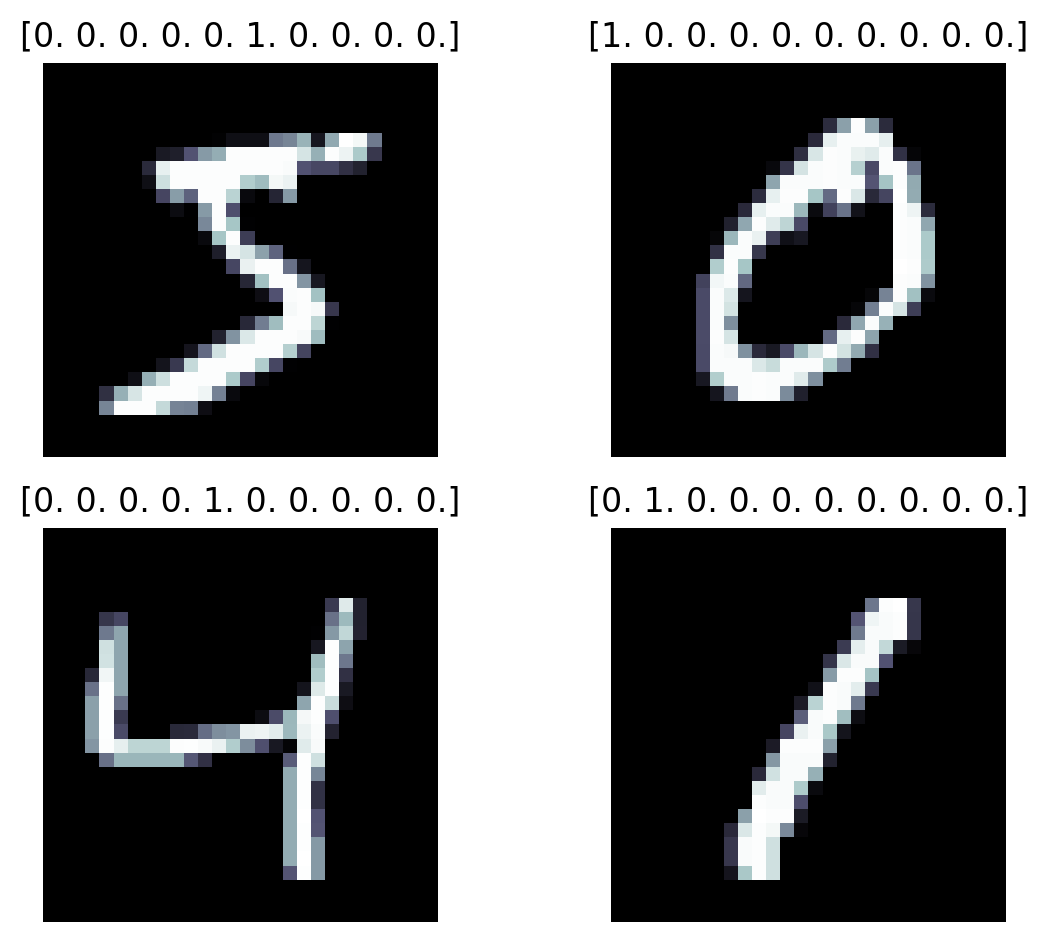

In [6]:
# (X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
# X_train = einops.rearrange(X_train, "s w h -> s (w h)") / 255
# X_test = einops.rearrange(X_test, "s w h -> s (w h)") / 255
X_train = X_train[..., None] / 255
X_test = X_test[..., None] / 255
y_train = jax.nn.one_hot(y_train, 10)
X_train = jnp.array(X_train)
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.ravel()):
    ax.imshow(X_train[i], cmap="bone")
    ax.set_title(y_train[i])
    ax.axis("off")
plt.tight_layout()

## Train

In [7]:
X_eval = X_test[:5_000]
y_eval = y_test[:5_000]

In [8]:
class CNN(nn.Module):
    num_arms: int = 10

    @nn.compact
    def __call__(self, x):
        x = x if len(x.shape) > 3 else x[None, :]
        x = nn.Conv(features=6, kernel_size=(5, 5))(x)
        x = nn.elu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = nn.Conv(features=16, kernel_size=(5, 5), padding="VALID")(x)
        x = nn.elu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=120)(x)
        x = nn.elu(x)
        x = nn.Dense(features=84)(x)
        x = nn.elu(x)
        x = nn.Dense(10, name="last_layer")(x)
        return x.squeeze()

model = CNN()

In [9]:
def plot_err_bound(df, ax, label, periods=5000, min_periods=None):
    min_periods = periods if min_periods is None else min_periods
    df.rolling(periods, min_periods=min_periods).mean().mean(axis=1).plot(label=label, ax=ax)

## Revised version

In [14]:
def callbackfn(bel_update, bel_pred, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat = agent.predict_fn(bel_pred, x)
    acc = y.argmax() == yhat.argmax()
    return (acc,)

In [15]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=0.1):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [16]:
n_sims = 10
keys = jax.random.PRNGKey(314)
keys = jax.random.split(keys, n_sims)
model = CNN()

In [17]:
n_obs = len(X_train)

In [18]:
%%time

def run_lrkf(key, rank=20):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    params = model.init(key_init, X_train[:1])
    agent = lrkf.LowRankCovarianceFilter(
        mean_fn,
        cov_fn,
        dynamics_covariance=0.01,
        rank=rank,
    )
    bel_init = agent.init_bel(params, cov=1.0, low_rank_diag=True)
    print(bel_init.mean.shape)
    
    cfn = partial(callbackfn, agent=agent)
    bel, hist_lrkf = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    return hist_lrkf

hist_lrkf = jax.vmap(run_lrkf)(keys)
hist_lrk = jax.tree.map(np.array, hist_lrkf)

(61706,)
CPU times: user 51.3 s, sys: 309 ms, total: 51.6 s
Wall time: 3min 5s


In [19]:
df_lrkf = pd.DataFrame(hist_lrkf[0].T)
df_lrkf.shape

(60000, 10)

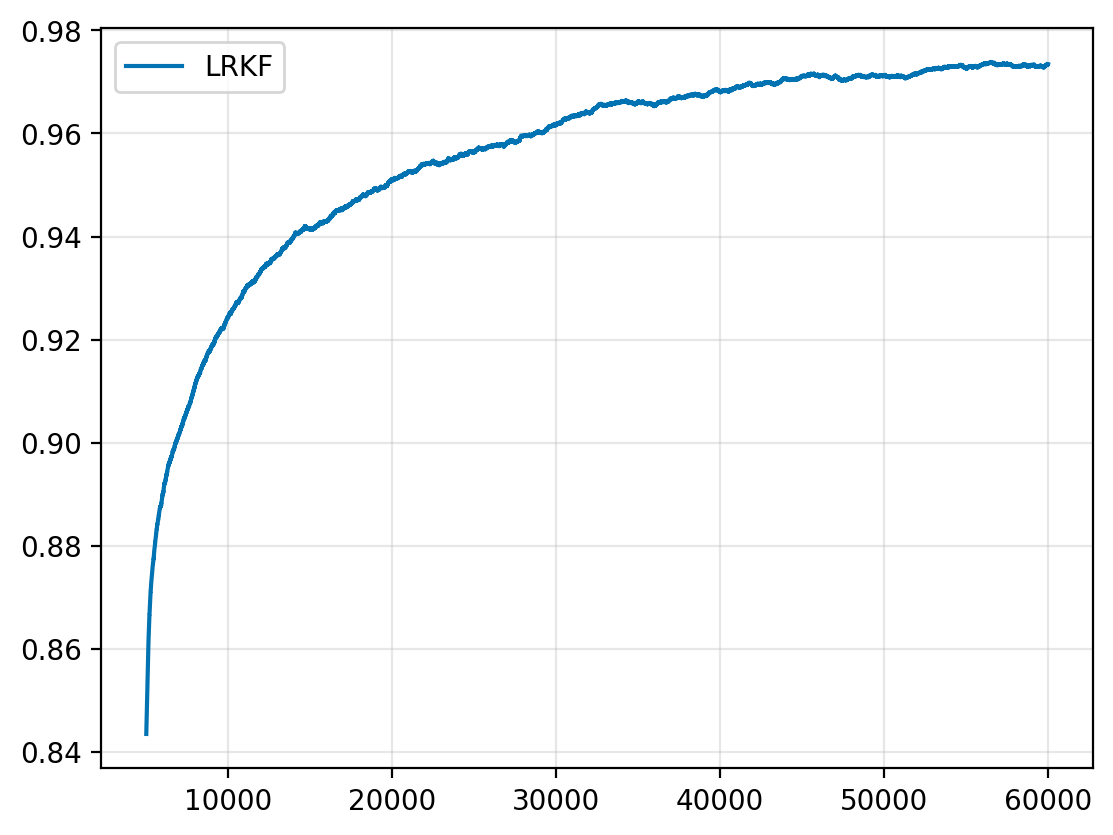

In [20]:
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plt.legend()
plt.grid(alpha=0.3)

# LoLoFi

In [21]:
def callbackfn(bel_update, bel_pred, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat = agent.predict_fn(bel_pred, x)
    acc = y.argmax() == yhat.argmax()
    return acc

In [22]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=1e-4):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [ ]:
%%time
def run_lolofi(key, rank=100):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    agent = flores.LowRankLastLayer(
        mean_fn, cov_fn, rank=rank, rank_last=50,
        # dynamics_hidden=1e-6, dynamics_last=1e-6,
        dynamics_hidden=0.01, dynamics_last=0.01,
    )
    params = model.init(key, X_train[:100])
    
    bel_init = agent.init_bel(params, cov_hidden=1.0, cov_last=1.0, low_rank_diag=True)
    
    cfn = partial(callbackfn, agent=agent)
    bel_flores, hist_flores = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    
    return hist_flores

hist_lolofi = jax.vmap(run_lolofi)(keys)
hist_lolofi = jax.tree.map(np.array, hist_lolofi)

In [ ]:
df_lolofi = pd.DataFrame(hist_lolofi.T)
df_lolofi.shape

In [ ]:
%%time
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_lolofi, ax, "LoLoFi")
plt.legend()
plt.grid(alpha=0.3)

## HiLoFi

In [ ]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=1e-4):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [ ]:
%%time
def run_hilofi(key, rank=50):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    agent = flores.LowRankLastLayer(
        mean_fn, cov_fn, rank=rank, rank_last=None,
        # dynamics_hidden=1e-6, dynamics_last=1e-6,
        dynamics_hidden=0.01, dynamics_last=0.01,
    )
    params = model.init(key, X_train[:100])
    
    bel_init = agent.init_bel(params, cov_hidden=1.0, cov_last=1.0, low_rank_diag=True)
    
    cfn = partial(callbackfn, agent=agent)
    bel_flores, hist_flores = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    
    return hist_flores

hist_hilofi = jax.vmap(run_hilofi)(keys)
hist_hilofi = jax.tree.map(np.array, hist_hilofi)

In [ ]:
df_hilofi = pd.DataFrame(hist_hilofi.T)
df_hilofi.shape

In [ ]:
%%time
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_lolofi, ax, "LoLoFi")
plot_err_bound(df_hilofi, ax, "HiLoFi")
plt.legend()
plt.grid(alpha=0.3)

## Low-rank (precision) filter (LoFi)

In [ ]:
from rebayes_mini.methods import low_rank_filter as lofi

In [ ]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=0.01):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [ ]:
%%time

def run_lofi(key, rank=50):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    agent = lofi.LowRankPrecisionFilter(
        mean_fn, cov_fn, rank=rank, dynamics_covariance=0.0,
    )
    params = model.init(key_init, X_train[:100])
    
    bel_init = agent.init_bel(params, cov=jnp.exp(-8))
    
    cfn = partial(callbackfn, agent=agent)
    bel, hist_lofi = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    return hist_lofi

hist_lofi = jax.vmap(run_lofi)(keys)
hist_lofi = jax.tree.map(np.array, hist_lofi)

In [ ]:
df_lofi = pd.DataFrame(hist_lofi.T)
df_lofi.shape

In [ ]:
%%time
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_lolofi, ax, "LoLoFi")
plot_err_bound(df_lofi, ax, "LoFi")
plt.legend()
plt.grid(alpha=0.3)

## Muon Shampoo

In [ ]:
from rebayes_mini.methods import replay_sgd

In [ ]:
def lossfn(params, counter, X, y, fn):
    yhat = fn(params, X)
    loss = optax.losses.softmax_cross_entropy(yhat, y)
    return (loss * counter).sum() / counter.sum()

In [ ]:
%%time

def run_muon(key):
    key_init, key_shuffle = jax.random.split(key)
    
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    params = model.init(key_init, X_train[:100])
    
    agent = replay_sgd.FifoSGD(
        model.apply,
        lossfn,
        tx=optax.contrib.muon(learning_rate=1e-3),
        buffer_size=1,
        dim_features=(28, 28, 1),
        dim_output=10
    )
    
    cfn = partial(callbackfn, agent=agent)
    bel_init = agent.init_bel(params)
    bel_muon, hist_muon = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    return hist_muon

hist_muon = jax.vmap(run_muon)(keys)
hist_muon = jax.tree.map(np.array, hist_muon)

In [ ]:
df_muon = pd.DataFrame(hist_muon.T)
df_muon.shape

In [ ]:
%%time
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_lolofi, ax, "LoLoFi")
plot_err_bound(df_hilofi, ax, "HiLoFi")
plot_err_bound(df_lofi, ax, "LoFi")
plot_err_bound(df_muon, ax, "Muon")
plt.legend()
plt.grid(alpha=0.3)

## Adamw

In [ ]:
%%time
def run_adamw(key):
    key_init, key_shuffle = jax.random.split(key)
    
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    params = model.init(key_init, X_train[:100])
    
    agent = replay_sgd.FifoSGD(
        model.apply,
        lossfn,
        tx=optax.adamw(learning_rate=1e-4),
        buffer_size=5,
        dim_features=(28, 28, 1),
        dim_output=10
    )
    
    cfn = partial(callbackfn, agent=agent)
    bel_init = agent.init_bel(params)
    bel, hist = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    return hist
    
hist_adamw = jax.vmap(run_adamw)(keys)
hist_adamw = jax.tree.map(np.array, hist_adamw)

In [ ]:
df_adamw = pd.DataFrame(hist_adamw.T)
df_adamw.shape

## Plot all results

In [ ]:
def plot_err_bound(df, ax, label, periods=5000, min_periods=None):
    min_periods = periods if min_periods is None else min_periods
    df.rolling(periods, min_periods=min_periods).mean().mean(axis=1).plot(label=label, ax=ax)
    lbound = df.rolling(periods, min_periods=min_periods).mean().quantile(0.25, axis=1)
    ubound = df.rolling(periods, min_periods=min_periods).mean().quantile(0.75, axis=1)
    ax.fill_between(lbound.index, lbound, ubound, alpha=0.4)

CPU times: user 42.2 s, sys: 244 ms, total: 42.5 s
Wall time: 42.3 s


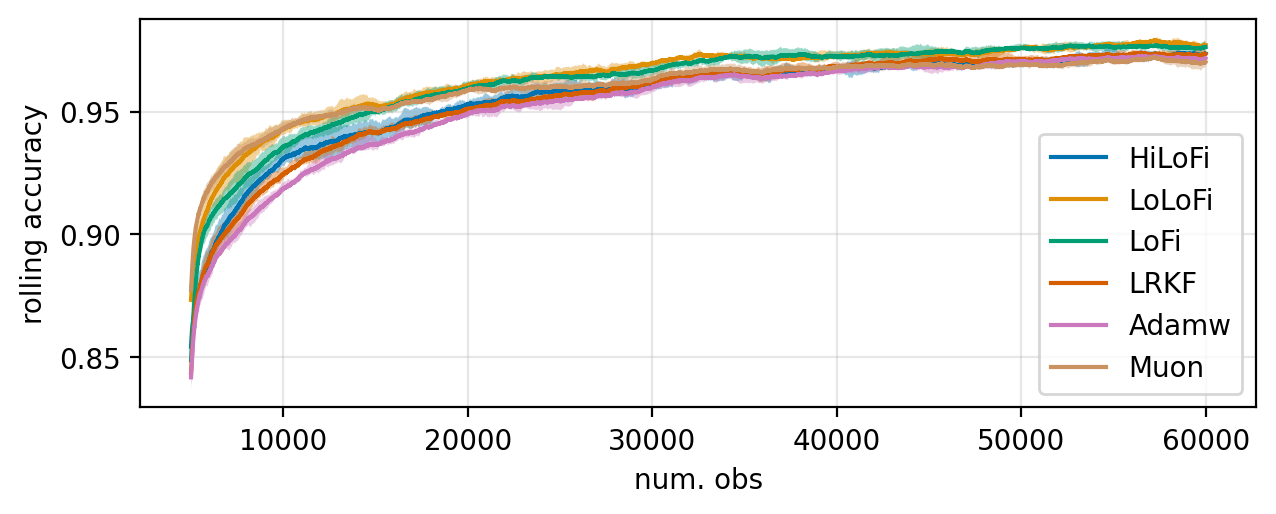

In [45]:
%%time
fig, ax = plt.subplots(figsize=(7.2, 4.2 * 0.6))
plot_err_bound(df_hilofi, ax, "HiLoFi")
plot_err_bound(df_lolofi, ax, "LoLoFi")
plot_err_bound(df_lofi, ax, "LoFi")
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_adamw, ax, "Adamw")
plot_err_bound(df_muon, ax, "Muon")
plt.legend()
plt.ylabel("rolling accuracy")
plt.xlabel("num. obs")
plt.grid(alpha=0.3)
# plt.savefig("../figures/mnist-online-classification.png", dpi=300, bbox_inches="tight")